In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [7]:
from copy import deepcopy

import dgl
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.data import load_data
from src.dataset import SatsDataset
from src.net import JobGCN
from src.utils import load_from_wandb

In [8]:
A, b, c, resultados, objetivos = load_data("../data/raw/97_9.jl")

optimals = torch.from_numpy(np.array([resultados[i,j] for i,j in enumerate(objetivos.argmax(-1))]))

g = SatsDataset.make_graph(A[-1], b[-1], c[-1])
x_opt = optimals[-1]

g

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


Graph(num_nodes={'con': 601, 'var': 194},
      num_edges={('con', 'c2v', 'var'): 7160, ('var', 'v2c', 'con'): 7160},
      metagraph=[('con', 'var', 'c2v'), ('var', 'con', 'v2c')])

In [11]:
xs = torch.randint(0, 2, (10, 194))

gs = list()
for x in xs:
    g_ = deepcopy(g)
    curr_feats = g_.nodes['var'].data['x']
    g_.nodes['var'].data['x'] = torch.hstack((
        # unsqueeze features dimension, if necessary
        curr_feats.view(curr_feats.shape[0],-1),
        x.view(x.shape[-1],-1),
    ))
    gs.append(g_)
batch_g = dgl.batch(gs)
batch_g

Graph(num_nodes={'con': 6010, 'var': 1940},
      num_edges={('con', 'c2v', 'var'): 71600, ('var', 'v2c', 'con'): 71600},
      metagraph=[('con', 'var', 'c2v'), ('var', 'con', 'v2c')])

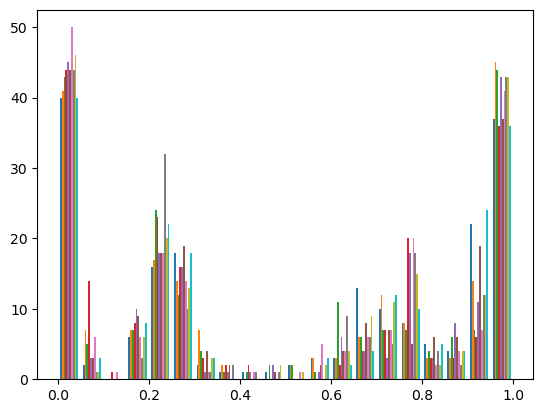

In [12]:
net = JobGCN(2, 1, readout_op=None)
net = load_from_wandb(net, 'j99aol9m', 'sat-gnn', 'model_best')
net.eval()

with torch.no_grad():
    y_hat = torch.sigmoid(net(batch_g))

plt.hist(y_hat, bins=np.arange(0,1.05,0.05))
plt.show()

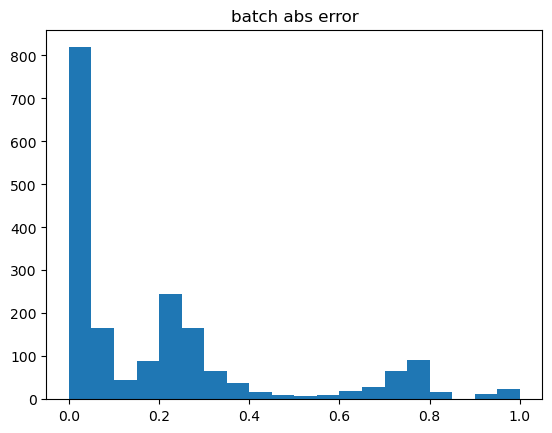

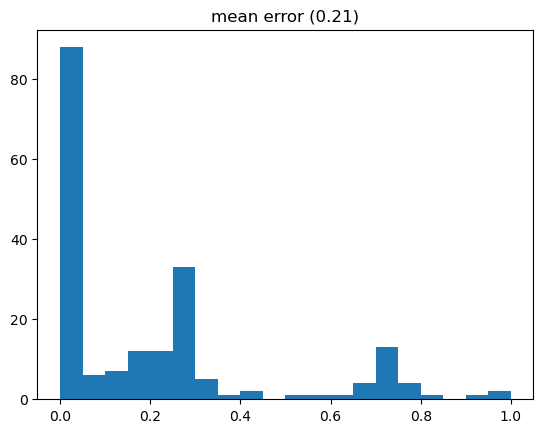

In [13]:
y_flip = 1 - y_hat
x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution
err = (x_hat - x_opt).abs()

plt.hist(err.flatten(), bins=np.arange(0,1.05,0.05))
plt.title('batch abs error')
plt.show()

plt.hist(err.mean(0), bins=np.arange(0,1.05,0.05))
plt.title(f'mean error ({err.mean():.2f})')
plt.show()

[13, 28, 90, 97, 117, 194] [tensor(1.), tensor(1.), tensor(0.9778), tensor(0.9691), tensor(0.9658), tensor(0.8557)]


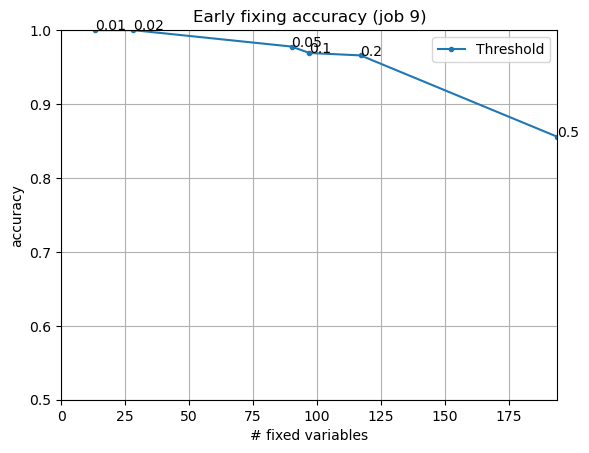

In [16]:
# thresholds = [.01, .02, .05, .1, .2, .3, .4, .5]
thresholds = [.01, .02, .05, .1, .2, .5]

accs = list()
ns = list()
for thresh in thresholds:
    most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) >= 1 - thresh)
    fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_opt)
    fixed_x_opt = x_opt[most_certain]

    acc = (fixed_x_hat == fixed_x_opt).sum() / fixed_x_opt.shape[0]

    accs.append(acc)
    ns.append(fixed_x_hat.shape[0])

fig, ax = plt.subplots()
ax.plot(ns, accs, '.-', label='Threshold')
ax.set_xlim((0, x_opt.shape[0]))
ax.set_ylim((.5, 1.))
ax.grid()
ax.legend()

ax.set_title('Early fixing accuracy (job 9)')
ax.set_xlabel('# fixed variables')
ax.set_ylabel('accuracy')

for i, thresh in enumerate(thresholds):
    ax.annotate(thresh, (ns[i], accs[i]))

print(ns, accs)
fig.show()